## Imports

In [1]:
from time import time
from typing import Callable

import matplotlib.pyplot as plt
from numpy.random import choice
import torch
from torch import Tensor
from torch.nn import BatchNorm2d, Conv2d, CrossEntropyLoss, Flatten, Linear, MaxPool2d, Module, ReLU, Sequential
from torch.optim import Adam, Optimizer
from torch.utils.data import DataLoader
from torchinfo import summary
from torchvision.datasets import CIFAR10
from torchvision.transforms import Compose, ToTensor, Normalize

## Parameters

In [2]:
batch_size = 64
epochs = 30
learning_rate = 0.001

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Load data

In [4]:
transforms = Compose([
  ToTensor(),
  Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [5]:
train_set = CIFAR10(root='.', train=True, transform=transforms, download=True)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

test_set = CIFAR10(root='.', train=False, transform=transforms, download=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
print(f'Train images shape: {train_loader.dataset.data.shape}')
print(f'Train labels size: {len(train_loader.dataset.targets)}')
print(f'Train images shape: {test_loader.dataset.data.shape}')
print(f'Train labels size: {len(test_loader.dataset.targets)}')

Train images shape: (50000, 32, 32, 3)
Train labels size: 50000
Train images shape: (10000, 32, 32, 3)
Train labels size: 10000


In [7]:
def plot_cifar10(dataloader: DataLoader, pred_func: Callable | None = None):
    data = dataloader.dataset.data
    targets = dataloader.dataset.targets
    classes = dataloader.dataset.classes
    random_ids = choice(data.shape[0], 64)
    plt.figure(figsize=(12, 12))
    for i, j in enumerate(random_ids):
      plt.subplot(8, 8, i + 1)
      plt.axis(False)
      if pred_func is None:
        plt.title(f'T: {classes[targets[j]]}')
      else:
        pred = pred_func(dataloader)
        plt.title(f'T: {classes[targets[j]]}\nP: {classes[pred[j]]}', color='k' if classes[targets[j]] == classes[pred[j]] else 'r')
      plt.tight_layout()
      plt.imshow(data[j])

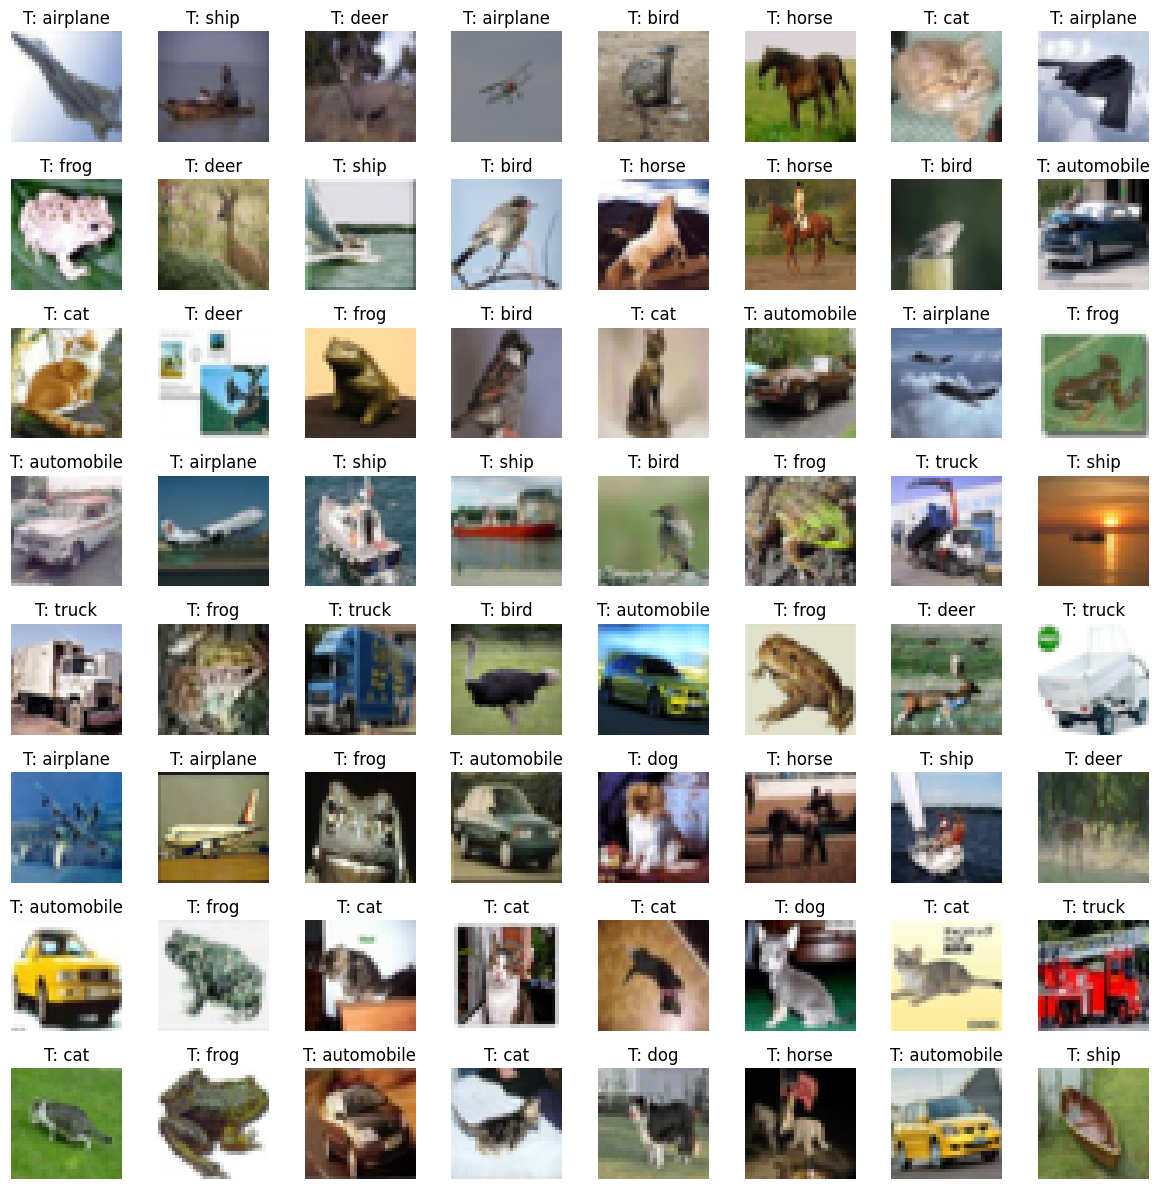

In [8]:
plot_cifar10(train_loader)

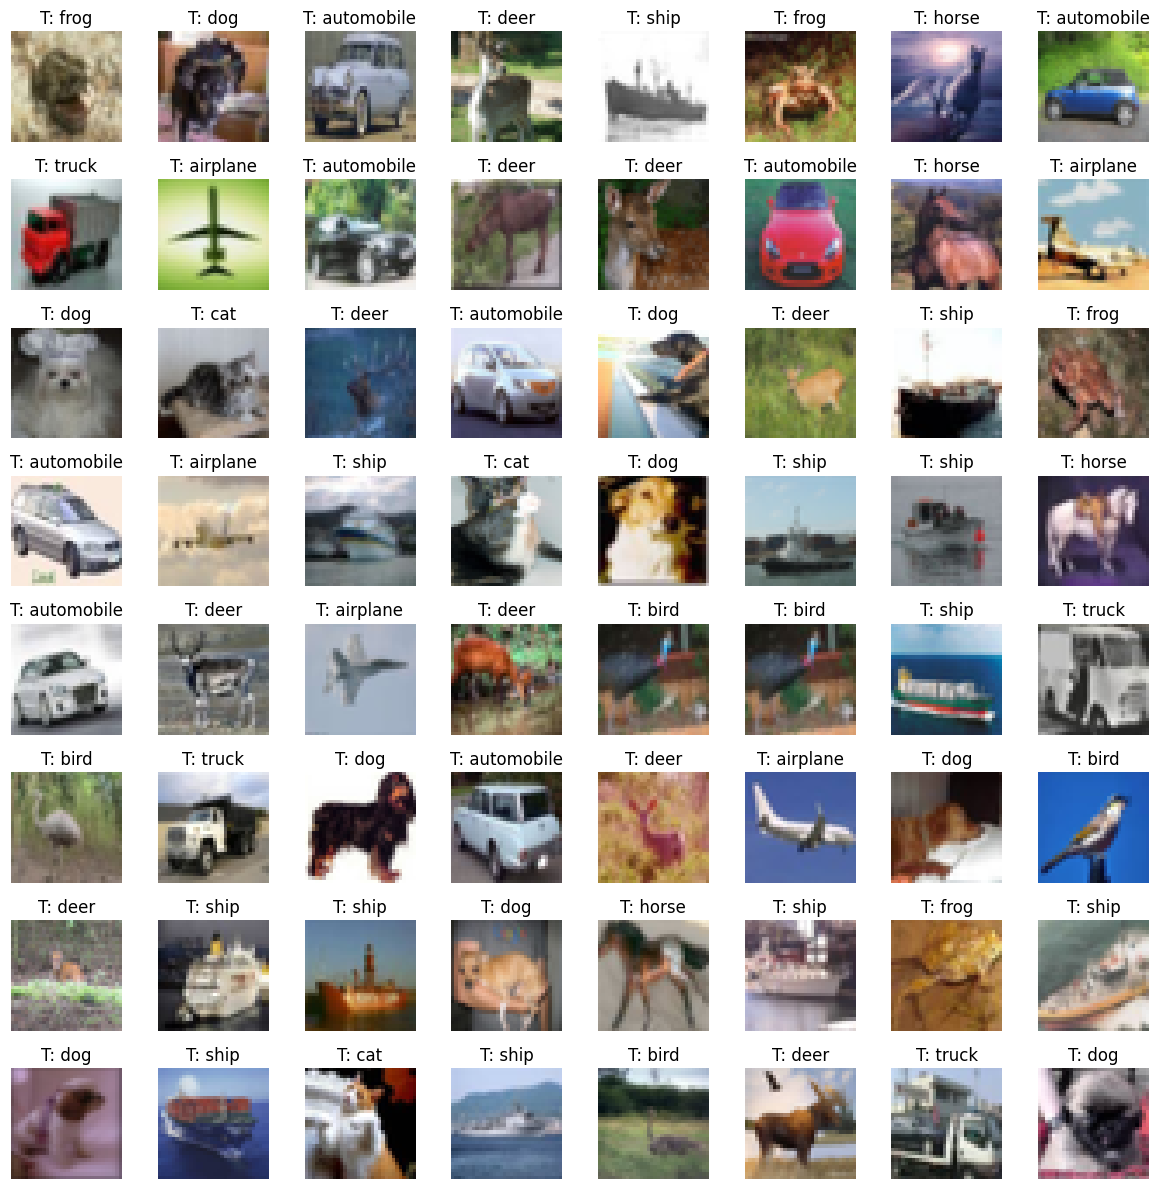

In [9]:
plot_cifar10(test_loader)

## Network class

In [10]:
class NN(Module):
  """
  VGG-13 w/ BatchNorm2d
  """
  def __init__(self):
    super().__init__()
    self.__block1 = Sequential(
      Conv2d(3, 64, 3, padding=1),
      BatchNorm2d(64),
      ReLU(),
      Conv2d(64, 64, 3, padding=1),
      BatchNorm2d(64),
      ReLU(),
      MaxPool2d(2)
    )
    self.__block2 = Sequential(
      Conv2d(64, 128, 3, padding=1),
      BatchNorm2d(128),
      ReLU(),
      Conv2d(128, 128, 3, padding=1),
      BatchNorm2d(128),
      ReLU(),
      MaxPool2d(2)
    )
    self.__block3 = Sequential(
      Conv2d(128, 256, 3, padding=1),
      BatchNorm2d(256),
      ReLU(),
      Conv2d(256, 256, 3, padding=1),
      BatchNorm2d(256),
      ReLU(),
      MaxPool2d(2)
    )
    self.__block4 = Sequential(
      Conv2d(256, 512, 3, padding=1),
      BatchNorm2d(512),
      ReLU(),
      Conv2d(512, 512, 3, padding=1),
      BatchNorm2d(512),
      ReLU(),
      MaxPool2d(2)
    )
    self.__block5 = Sequential(
      Conv2d(512, 512, 3, padding=1),
      BatchNorm2d(512),
      ReLU(),
      Conv2d(512, 512, 3, padding=1),
      BatchNorm2d(512),
      ReLU(),
      MaxPool2d(2)
    )
    self.__block6 = Sequential(
      Flatten(),
      Linear(512, 4096),
      ReLU(),
      Linear(4096, 4096),
      ReLU(),
      Linear(4096, 10)
    )

  def forward(self, X: Tensor) -> Tensor:
    pred = self.__block1(X)
    pred = self.__block2(pred)
    pred = self.__block3(pred)
    pred = self.__block4(pred)
    pred = self.__block5(pred)
    pred = self.__block6(pred)
    return pred

## Train

In [ ]:
def train(dataloader: DataLoader,
          model: Module,
          loss_fn: Module,
          optimizer: Optimizer,
          epochs: int) -> tuple[list[float], list[float]]:
  model.train()
  loss_data: list[float] = []
  accuracy_data: list[float] = []
  for epoch in range(epochs):
    start_time = time()
    # train by batches
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)
      optimizer.zero_grad()
      pred = model(X)
      loss = loss_fn(pred, y)
      loss.backward()
      optimizer.step()
    # test on train data
    epoch_loss, epoch_accuracy = test(dataloader, model, loss_fn)
    loss_data.append(epoch_loss)
    accuracy_data.append(epoch_accuracy)
    epoch_time = time() - start_time
    print(f'[Epoch {epoch + 1 :02d}/{epochs}] loss = {epoch_loss :10.6f}, accuracy = {epoch_accuracy :10.6f}, time = {epoch_time :8.3f}')
  model.eval()
  return loss_data, accuracy_data

def test(dataloader: DataLoader,
         model: Module,
         loss_fn: Module) -> tuple[float, float]:
  loss, accuracy = 0.0, 0.0
  with torch.no_grad():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)
      pred = model(X)
      loss += loss_fn(pred, y).item() * len(X)
      accuracy += (pred.argmax(1) == y).type(torch.float).sum().item()
  return loss / len(dataloader.dataset), accuracy / len(dataloader.dataset)

def predict(dataloader: DataLoader, model: Module) -> list[int]:
  pred: list[int] = []
  with torch.no_grad():
    for X, _ in dataloader:
      pred.extend(model(X.to(device)).argmax(1).tolist())
  return pred

In [12]:
model = NN().to(device)
loss_fn = CrossEntropyLoss().to(device)
optimizer = Adam(model.parameters(), lr=learning_rate)

summary(model, input_size=(batch_size, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
NN                                       [64, 10]                  --
├─Sequential: 1-1                        [64, 64, 16, 16]          --
│    └─Conv2d: 2-1                       [64, 64, 32, 32]          1,792
│    └─BatchNorm2d: 2-2                  [64, 64, 32, 32]          128
│    └─ReLU: 2-3                         [64, 64, 32, 32]          --
│    └─Conv2d: 2-4                       [64, 64, 32, 32]          36,928
│    └─BatchNorm2d: 2-5                  [64, 64, 32, 32]          128
│    └─ReLU: 2-6                         [64, 64, 32, 32]          --
│    └─MaxPool2d: 2-7                    [64, 64, 16, 16]          --
├─Sequential: 1-2                        [64, 128, 8, 8]           --
│    └─Conv2d: 2-8                       [64, 128, 16, 16]         73,856
│    └─BatchNorm2d: 2-9                  [64, 128, 16, 16]         256
│    └─ReLU: 2-10                        [64, 128, 16, 16]         --
│

In [13]:
train_loss, train_accuracy = train(train_loader, model, loss_fn, optimizer, epochs)

[Epoch 01/30] loss =   1.420995, accuracy =   0.463340, time =   34.918
[Epoch 02/30] loss =   0.895301, accuracy =   0.682300, time =   27.504
[Epoch 03/30] loss =   0.719976, accuracy =   0.750680, time =   30.062
[Epoch 04/30] loss =   0.567755, accuracy =   0.805260, time =   28.716
[Epoch 05/30] loss =   0.479057, accuracy =   0.841300, time =   31.683
[Epoch 06/30] loss =   0.390274, accuracy =   0.867760, time =   30.148
[Epoch 07/30] loss =   0.295107, accuracy =   0.903520, time =   27.941
[Epoch 08/30] loss =   0.250154, accuracy =   0.916380, time =   27.614
[Epoch 09/30] loss =   0.180050, accuracy =   0.941980, time =   29.863
[Epoch 10/30] loss =   0.168103, accuracy =   0.943340, time =   28.397
[Epoch 11/30] loss =   0.173063, accuracy =   0.943960, time =   28.197
[Epoch 12/30] loss =   0.096900, accuracy =   0.968600, time =   28.469
[Epoch 13/30] loss =   0.092933, accuracy =   0.968060, time =   28.115
[Epoch 14/30] loss =   0.058737, accuracy =   0.980720, time =  

## Results

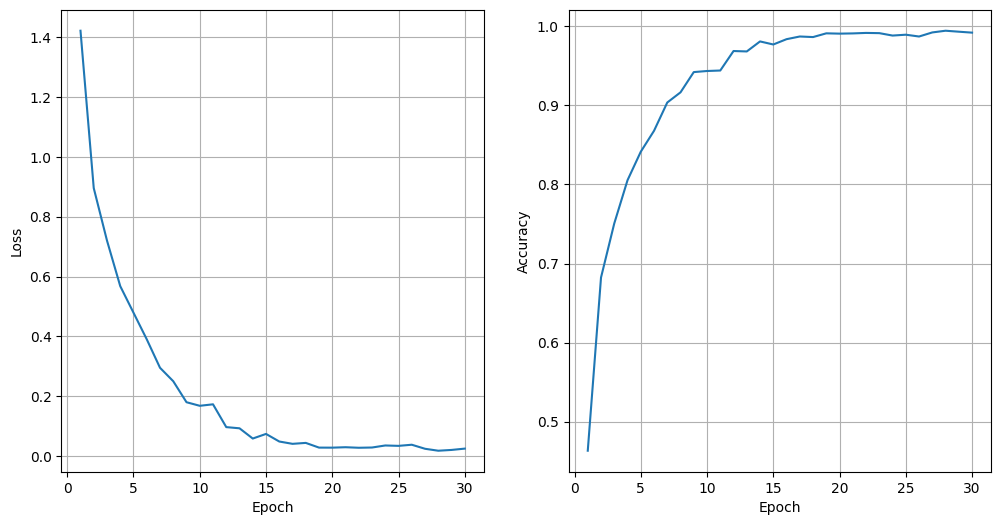

In [14]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.plot(range(1, epochs + 1), train_loss)
plt.subplot(1, 2, 2)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.plot(range(1, epochs + 1), train_accuracy)
plt.show()

In [15]:
test_loss, test_accuracy = test(test_loader, model, loss_fn)
print(f'Test data result: loss = {test_loss :10.6f}, accuracy = {test_accuracy :10.6f}')

Test data result: loss =   0.715686, accuracy =   0.860400


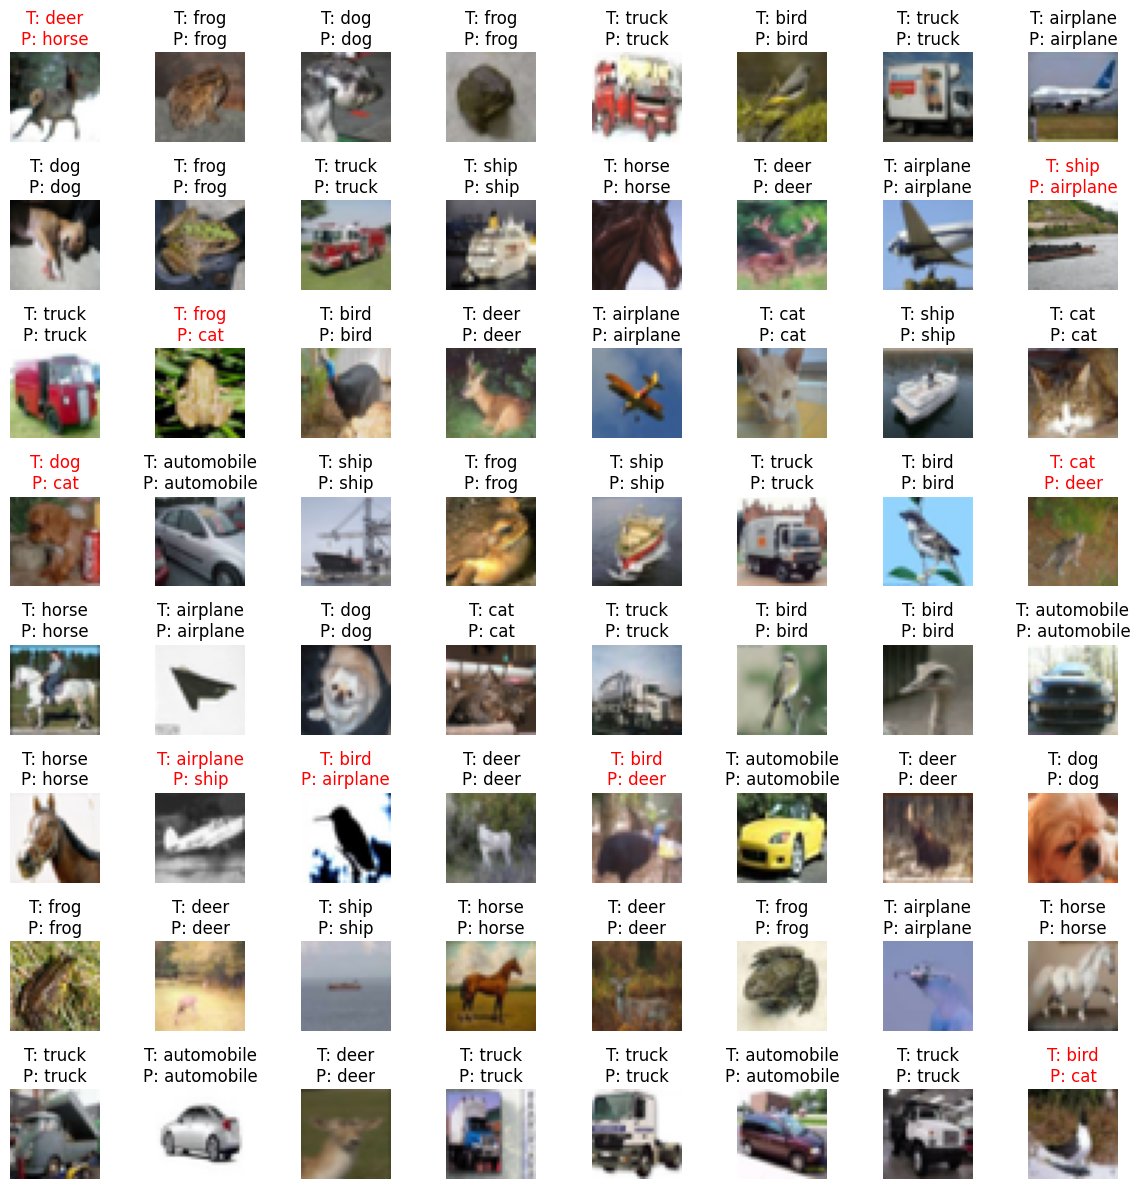

In [16]:
plot_cifar10(test_loader, lambda dataloader: predict(dataloader, model))